In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
pd.options.mode.chained_assignment = None  # default='warn'
os.getcwd()

'F:\\KARTIK\\2021\\Freezing of Gait'

In [2]:
data_path = os.path.join(os.getcwd(), 'dataset_fog_release', 'dataset', 'features', 'final_features.csv')
dataset = pd.read_csv(data_path)
print(dataset.shape)
print(dataset.head())

(12658, 183)
   Unnamed: 0  0  Minimum_A_F  Maximum_A_F  Median_A_F   Mean_A_F  \
0           0  0         -121           90       -50.0 -50.875000   
1           1  0         -121           40       -50.0 -49.000000   
2           2  0          -90           50       -50.0 -48.437500   
3           3  0         -161           40       -50.0 -52.390625   
4           4  0         -141           20       -60.0 -58.656250   

   ArmMean_A_F    RMS_A_F  Variance_A_F    STD_A_F  ...   ENt_A_F   ENt_A_V  \
0     0.000000  64.817773   1613.078125  40.163144  ...  2.848596  2.773791   
1     0.000000  60.410833   1248.468750  35.333677  ...  2.367487  3.110655   
2     0.000000  55.761770    763.183594  27.625778  ...  2.113819  3.063275   
3    34.896197  63.512179   1289.019287  35.902915  ...  2.267055  2.900160   
4    48.458215  64.156060    675.444336  25.989312  ...  3.036838  2.981486   

    ENt_A_L   ENt_L_F   ENt_L_V   ENt_L_L   ENt_T_F   ENt_T_V   ENt_T_L  \
0  2.627315  1.553937 

In [3]:
len(dataset[dataset['0'] == 0])

10804

In [10]:
# size of walk is 1.5 times the size of prefog

In [29]:
precision_list = []
recall_list = []
F1_score_list = []
accuracy_list = []

# Format of list elements: 
#                            list[T_prefog][model_no]
for T_prefog in range(1,10):
    
    size_of_FOG = 237 
    size_of_prefog = size_of_FOG * T_prefog    
    size_of_walk = int(1.5 * size_of_FOG)
    
    y_0 = dataset[dataset['0'] == 0].sample(n = size_of_walk)
    y_1 = dataset[dataset['0'] == 1].sample(n = size_of_prefog)
    y_2 = dataset[dataset['0'] == 2]
    
    dataset_2 = pd.concat([y_0, y_1, y_2], axis = 0)
    #print(len(y_1.index))

    dataset_2 = dataset_2.drop(['Unnamed: 0'], axis = 1)
    #print(dataset_2.head())
    #print(dataset_2.count())
    total_features = [
       
        7, 8, -1, 22, 37,
        1, 6, 15, 21, 30, 
        2, 16, 17, 31, 36,
        9, 10, 23, 24, 37,
        45, 145, 146, 172, 173,
        38, 39, 147, 174, 32
        
    ]
    
    for model_no in range(1, 7):
        
        no_of_ftrs = 5 * model_no
        #print(no_of_ftrs)
        ftrs_for_model = total_features[:no_of_ftrs]
        df = dataset_2.iloc[:, ftrs_for_model]
        df['0'] = dataset_2['0']
        #print(df.head())
        
        # Split the data for the classifier
        y = df['0'].values
        X = df.iloc[:,:-1].values
        
        #print(len(y))
        X, y = shuffle(X, y, random_state = 2)
        
        # Initiate the 10 - fold split 
        kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2)
        
        # Initiate a random forest model
        clf = RandomForestClassifier(
            n_estimators=500,
            criterion='gini',
            max_depth=50,
            min_samples_split=5,
            min_samples_leaf=15,
            max_features='auto',
            max_leaf_nodes=None,
            min_impurity_split=None,
            bootstrap=True,
            n_jobs=-1,
            random_state=2,
            class_weight='balanced'
            )
        
        score = cross_val_score(clf, X, y, cv= kf, scoring="accuracy")
        print(f'Average score: {"{:.2f}".format(score.mean())}')
        
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2, stratify = y)
        
        m = clf.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        accuracy_score(y_test, y_pred)
        
        cnf = confusion_matrix(y_test, y_pred)
        
        
#         # For class pre-FoG
#         tp = cnf[1][1]
#         tn = cnf[0][0] + cnf[0][2] + cnf[2][0] + cnf[2][2]
#         fp = cnf[1][0] + cnf[1][2]
#         fn = cnf[0][1] + cnf[2][1]
        
#         precision = tp/(tp + fp)
#         recall =  tp / (tp + fn)    #sensitivity
#         F1_score = (2*tp) / (2*tp + fp + fn)
        
         # For class FoG
        tp = cnf[2][2]
        tn = cnf[0][0] + cnf[0][1] + cnf[1][0] + cnf[1][1]
        fp = cnf[2][0] + cnf[2][1]
        fn = cnf[0][2] + cnf[1][2]
        
        precision = tp/(tp + fp)
        recall =  tp / (tp + fn)    #sensitivity
        F1_score = (2*tp) / (2*tp + fp + fn)
        
        
        
        print("Time: ", T_prefog, end = "\n")
        print("The evaluation metrics are:\nprecision = {},\nrecall = {}, \nF1-score = {}".format(precision, recall, F1_score) )
        
#         precision_list.append(T_prefog)
#         recall_list.append(T_prefog)
#         F1_score_list.append(T_prefog)
#         accuracy_list.append(T_prefog)
        
        
        
#         precision_list[-1].append(precision)
#         recall_list[-1].append(recall)
#         F1_score_list[-1].append(F1_score)
#         accuracy_list[-1].append(accuracy)

Average score: 0.53
Time:  1
The evaluation metrics are:
precision = 0.4576271186440678,
recall = 0.34177215189873417, 
F1-score = 0.391304347826087
Average score: 0.55
Time:  1
The evaluation metrics are:
precision = 0.4406779661016949,
recall = 0.37142857142857144, 
F1-score = 0.40310077519379844
Average score: 0.58
Time:  1
The evaluation metrics are:
precision = 0.4745762711864407,
recall = 0.3684210526315789, 
F1-score = 0.4148148148148148
Average score: 0.56
Time:  1
The evaluation metrics are:
precision = 0.5084745762711864,
recall = 0.40540540540540543, 
F1-score = 0.45112781954887216
Average score: 0.57
Time:  1
The evaluation metrics are:
precision = 0.5084745762711864,
recall = 0.4225352112676056, 
F1-score = 0.46153846153846156
Average score: 0.58
Time:  1
The evaluation metrics are:
precision = 0.5423728813559322,
recall = 0.4155844155844156, 
F1-score = 0.47058823529411764
Average score: 0.52
Time:  2
The evaluation metrics are:
precision = 0.3389830508474576,
recall = 0.

KeyboardInterrupt: 

In [23]:
ftr_nos = [i for i in range(5, 50, 5)]

f1_5_walk = [0.79, 0.82, 0.81, 0.77, 0.8, 0.84, 0.85, 0.83, 0.88, 0.64, 0.55, 0.76, 0.89,]
f1_5_fog = [0.73, 0.43, 0.77, 0.63, 0.67, 0.84, 0.748, 0.68, 0.768, 0.43, 0.35, 0.55, 0.844]

f1_10_walk = [0.744, 0.840, 0.867, 0.766, 0.874, 0.8849, 0.853, 0.787, 0.845, 0.77, 0.666,0.825,0.93] 
f1_10_fog = [0.500, 0.80, 0.727, 0.76, 0.732, 0.838, 0.739, 0.60, 0.771, 0.678, 0.666, 0.654, 0.87]

f1_15_walk = [0.743, 0.800, 0.841, 0.868, 0.963, 0.867, 0.753, 0.750, 0.89, 0.640, 0.53, 0.782, 0.934]
f1_15_fog = [0.531, 0.80, 0.668, 0.70, 0.75, 0.881, 0.80, 0.546, 0.818, 0.462, 0.80, 0.650, 0.874]

f1_20_walk = [0.743, 0.90, 0.775, 0.862, 0.866, 0.837, 0.875, 0.821, 0.911, 0.81, 0.53, 0.82,0.947]
f1_20_fog = [0.526, 0.80, 0.731, 0.76, 0.741, 0.70, 0.719, 0.638, 0.829, 0.583, 0.80, 0.750, 0.89]

f1_25_walk = [0.687, 0.80, 0.783, 0.841, 0.868, 0.885, 0.842, 0.787, 0.88,0.772, 0.57, 0.867, 0.947]
f1_25_fog = [0.473, 0.60, 0.729, 0.781,  0.713, 0.836, 0.686, 0.62, 0.80, 0.526, 0.80, 0.72, 0.88]

f1_30_walk = [0.741, 0.62, 0.816, 0.827, 0.846, 0.873, 0.844, 0.763, 0.887, 0.65, 0.61, 0.782, 0.93]
f1_30_fog = [0.681, 0.55, 0.783, 0.643, 0.728, 0.70, 0.70, 0.627, 0.818, 0.462, 0.73, 0.646, 0.86]

f1_35_walk = [0.739, 0.76, 0.85, 0.879, 0.863, 0.891, 0.845, 0.83, 0.883, 0.708, 0.537, 0.813, 0.925]
f1_35_fog = [0.342, 0.788, 0.816, 0.70, 0.736, 0.784, 0.712, 0.631, 0.822, 0.45, 0.40, 0.687, 0.86]

f1_40_walk = [0.732, 0.76, 0.85, 0.871, 0.840, 0.823, 0.841, 0.814, 0.867, 0.692, 0.666, 0.834, 0.925]
f1_40_fog = [0.386, 0.788, 0.816, 0.673, 0.67, 0.522, 0.675, 0.638, 0.811, 0.62, 0.45, 0.725, 0.842]

f1_45_walk = [0.738, 0.89, 0.812, 0.80, 0.842, 0.891, 0.869, 0.779, 0.873, 0.662, 0.540, 0.856, 0.93]
f1_45_fog = [0.386, 0.662, 0.782, 0.724, 0.667, 0.591, 0.675, 0.573, 0.786, 0.586, 0.40, 0.75, 0.824]

f1_5_walk = np.mean(f1_5_walk)
f1_5_fog = np.mean(f1_5_fog)

f1_10_walk = np.mean(f1_10_walk)
f1_10_fog = np.mean(f1_10_fog)

f1_15_walk = np.mean(f1_15_walk)
f1_15_fog = np.mean(f1_15_fog)

f1_20_walk = np.mean(f1_20_walk)
f1_20_fog = np.mean(f1_20_fog)

f1_25_walk = np.mean(f1_25_walk)
f1_25_fog = np.mean(f1_25_fog)

f1_30_walk = np.mean(f1_30_walk)
f1_30_fog = np.mean(f1_30_fog)

f1_35_walk = np.mean(f1_35_walk)
f1_35_fog = np.mean(f1_35_fog)

f1_40_walk = np.mean(f1_40_walk)
f1_40_fog = np.mean(f1_40_fog)

f1_45_walk = np.mean(f1_45_walk)
f1_45_fog = np.mean(f1_45_fog)

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
list_f1_walk = [
    f1_5_walk,
    f1_10_walk,
    f1_15_walk,
    f1_20_walk,
    f1_25_walk,
    f1_30_walk,
    f1_35_walk,
    f1_40_walk,
    f1_45_walk
]

list_f1_fog = [
    f1_5_fog,
    f1_10_fog,
    f1_15_fog,
    f1_20_fog,
    f1_25_fog,
    f1_30_fog,
    f1_35_fog,
    f1_40_fog,
    f1_45_fog
]

Text(0.5, 1.0, 'Average F1 Score Performance with features')

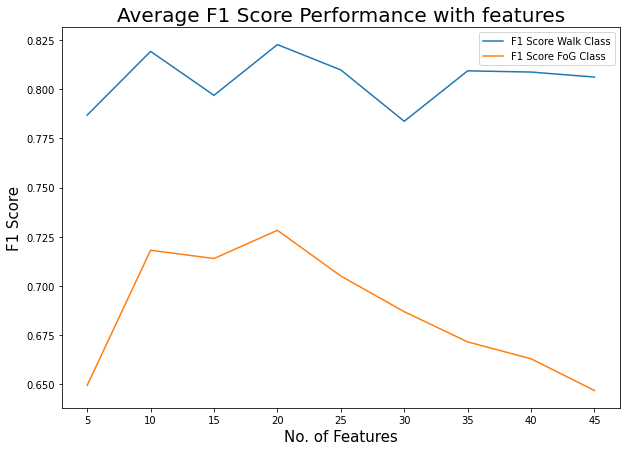

In [40]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.plot(ftr_nos, list_f1_walk)
plt.plot(ftr_nos, list_f1_fog)
plt.legend(['F1 Score Walk Class', 'F1 Score FoG Class'])
plt.xlabel("No. of Features", fontdict = {'fontsize' : 15})
plt.ylabel("F1 Score", fontdict = {'fontsize' : 15})
plt.title("Average F1 Score Performance with features", fontdict = {'fontsize' : 20})


In [27]:
list_f1_walk

[0.786923076923077,
 0.819376923076923,
 0.7969999999999999,
 0.8228461538461538,
 0.809923076923077,
 0.7837692307692307,
 0.8094615384615386,
 0.8088461538461539,
 0.8063076923076924]